# Heart Attack Triggers

`by Nyanda Redwood | November 20, 2022`

# Introduction

In [1]:
# Import libraries needed for this analysis.
import altair as alt
import numpy as np
import pandas as pd
import string
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    normalize,
    scale,
    )
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.svm import SVC, SVR

In [2]:
# Read in the table Dataset_DSChallenge.csv.
awake_df = pd.read_csv("Dataset_DSChallenge.csv")

In [3]:
# let's look at the first couple rows of our data
awake_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,o2Saturation
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0,98.6
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0,98.6
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0,98.6
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0,98.6
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0,98.1


In [4]:
# let's clean our feature names so that we understand them
awake_df = awake_df.rename(columns={'cp': 'chest_pain', 'trtbps': 'Rblood_pressure',
                                   'chol': 'cholesterol', 'fbs': 'Fblood_sugar', 'restecg': 'Rest_ECG',
                                   'thalachh': 'Max_heart_rate', 'exng': 'exercize_angina',
                                   'slp': 'slope', 'caa': 'major_vessels', 'thall': 'TStress_result',
                                   'output': 'Heart_attack', 'o2Saturation':'Blood_oxygen'})
awake_df.head()

,age,sex,chest_pain,Rblood_pressure,cholesterol,Fblood_sugar,Rest_ECG,Max_heart_rate,exercize_angina,oldpeak,slope,major_vessels,TStress_result,Heart_attack,Blood_oxygen
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0,98.6
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0,98.6
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0,98.6
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0,98.6
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0,98.1


In [5]:
# Use .info() to find out more about our dataset.
awake_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3586 entries, 0 to 3585
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              303 non-null    float64
 1   sex              303 non-null    float64
 2   chest_pain       303 non-null    float64
 3   Rblood_pressure  303 non-null    float64
 4   cholesterol      303 non-null    float64
 5   Fblood_sugar     303 non-null    float64
 6   Rest_ECG         303 non-null    float64
 7   Max_heart_rate   303 non-null    float64
 8   exercize_angina  303 non-null    float64
 9   oldpeak          303 non-null    float64
 10  slope            303 non-null    float64
 11  major_vessels    303 non-null    float64
 12  TStress_result   303 non-null    float64
 13  Heart_attack     303 non-null    float64
 14  Blood_oxygen     3586 non-null   float64
dtypes: float64(15)
memory usage: 420.4 KB


Our dataset has 15 features. The target feature is `Heart_attack`. 14 features have 303 values, and noticeably the feature `Blood_oxygen` has 3586 values. A close examination reveals that our dataset is only complete for the first 303 entries. This explains the discrepancy between the feature `Blood_oxygen` and all other features. We will remove rows with null values, NaN.

In [6]:
# Remove NaN values in our target feature, FatLevel.
awake_df = awake_df.dropna(subset=["Heart_attack"])
awake_df.head()

,age,sex,chest_pain,Rblood_pressure,cholesterol,Fblood_sugar,Rest_ECG,Max_heart_rate,exercize_angina,oldpeak,slope,major_vessels,TStress_result,Heart_attack,Blood_oxygen
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0,98.6
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0,98.6
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0,98.6
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0,98.6
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0,98.1


In [7]:
# Verify that our NaN are removed
awake_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              303 non-null    float64
 1   sex              303 non-null    float64
 2   chest_pain       303 non-null    float64
 3   Rblood_pressure  303 non-null    float64
 4   cholesterol      303 non-null    float64
 5   Fblood_sugar     303 non-null    float64
 6   Rest_ECG         303 non-null    float64
 7   Max_heart_rate   303 non-null    float64
 8   exercize_angina  303 non-null    float64
 9   oldpeak          303 non-null    float64
 10  slope            303 non-null    float64
 11  major_vessels    303 non-null    float64
 12  TStress_result   303 non-null    float64
 13  Heart_attack     303 non-null    float64
 14  Blood_oxygen     303 non-null    float64
dtypes: float64(15)
memory usage: 37.9 KB


Above we see that our data is now cleaned of all null values. Let's now correct the data types of the categorical features from float64.

In [8]:
# Change the dtypes of categorical variables from float64
for col in ['sex', 'chest_pain', 'Fblood_sugar', 'Rest_ECG', 'exercize_angina', 'slope', 'TStress_result']:
    awake_df[col] = awake_df[col].astype('category')

In [9]:
awake_df.dtypes

age                 float64
sex                category
chest_pain         category
Rblood_pressure     float64
cholesterol         float64
Fblood_sugar       category
Rest_ECG           category
Max_heart_rate      float64
exercize_angina    category
oldpeak             float64
slope              category
major_vessels       float64
TStress_result     category
Heart_attack        float64
Blood_oxygen        float64
dtype: object

In [10]:
# Use .describe() to find out more about our dataset
awake_df.describe()

,age,Rblood_pressure,cholesterol,Max_heart_rate,oldpeak,major_vessels,Heart_attack,Blood_oxygen
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.729373,0.544554,97.484488
std,9.082101,17.538143,51.830751,22.905161,1.161075,1.022606,0.498835,0.352649
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,96.500000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000,97.500000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000,1.000000,97.500000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000,1.000000,97.500000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000,98.600000


Above we can readily see some quick statistics on the dataset such as mean, minimum and maximum values. For instance, the mean age is around 54, the mean oxygen saturation in the blood is around 97. The youngest person is 29 and the oldest is 77, the lowest heart rate is 71 and the highest is 202, and the lowest level of oxygen saturation in the blood is 96.5; the highest level is 98.6.

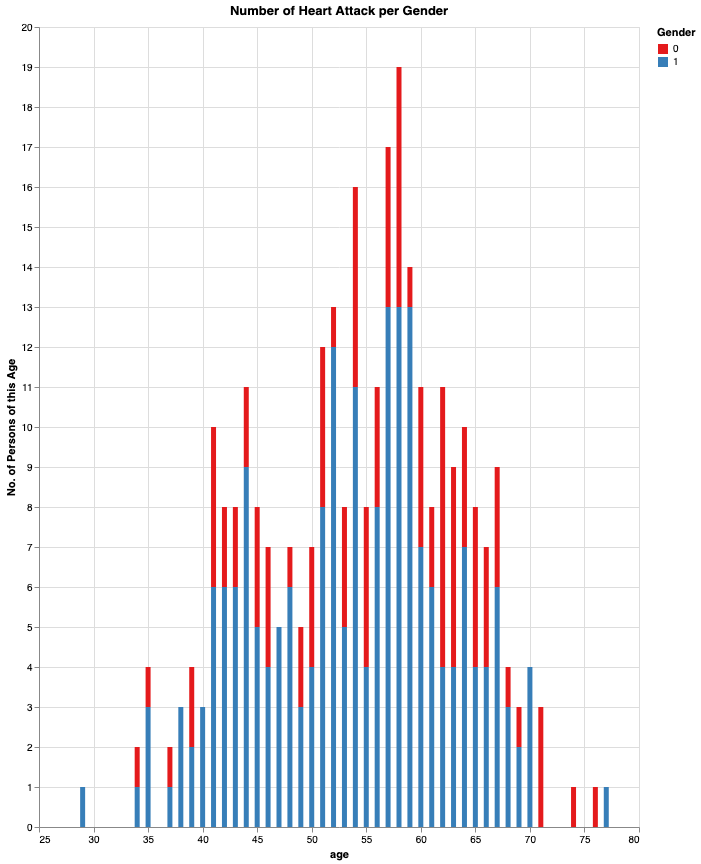

In [39]:
# Exploratory Interactive Graph to see the relationship between age, gender, and health metrics

fig1 = ( 
    alt.Chart(awake_df)
    .mark_bar()
    .encode(
        alt.X("age"),
        alt.Y("count()", title ="No. of Persons of this Age"),
        alt.Color("sex:N", scale=alt.Scale(scheme="set1"), title="Gender"
        ),
        tooltip=[
            "chest_pain:Q",
            "Rblood_pressure:Q",
            "cholesterol:Q",
            "Fblood_sugar:Q",
            "Rest_ECG:Q",
            "Max_heart_rate:Q",
            "Blood_oxygen:Q",
            "Heart_attack:N"
        ],
    )
    .properties(title="Number of Heart Attack per Gender", width=600, height=800)
)
fig1

In [38]:
# pip install vega
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [36]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

From our dataset we know that some of the features are categorical and some are numerical. Below we will make a list of the numerical columns.

In [12]:
# Make a list of all the numeric columns
numeric_cols = (
    awake_df[["age", "Rblood_pressure","cholesterol", "Max_heart_rate", "Blood_oxygen", "major_vessels", "oldpeak"]].columns.tolist()
)
numeric_cols

['age',
 'Rblood_pressure',
 'cholesterol',
 'Max_heart_rate',
 'Blood_oxygen',
 'major_vessels',
 'oldpeak']

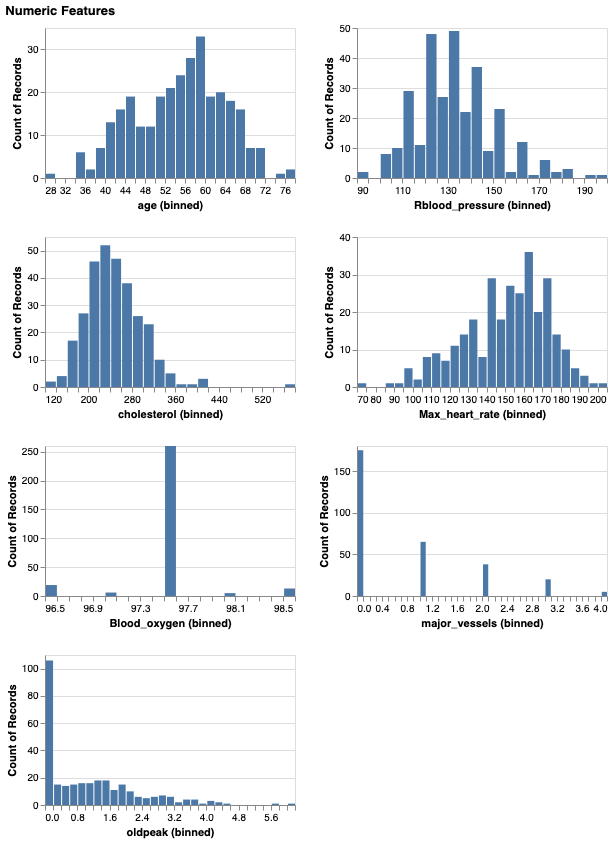

In [40]:
# Plot the numeric columns

numeric_plot = (
    alt.Chart(awake_df)
    .mark_bar()
    .encode(
        alt.X(alt.repeat(), type="quantitative", bin=alt.Bin(maxbins=40)),
        alt.Y("count()"),
    )
    .properties(width=250, height=150)
    .repeat(numeric_cols, columns=2, title = "Numeric Features")
)
numeric_plot

In [14]:
# Make a dataframe with the numeric columns to use in a correlation plot
corr_df = (
    awake_df[numeric_cols].corr("pearson").stack().reset_index(name="correlation")
)
corr_df.head()

,level_0,level_1,correlation
0,age,age,1.000000
1,age,Rblood_pressure,0.279351
2,age,cholesterol,0.213678
3,age,Max_heart_rate,-0.398522
4,age,Blood_oxygen,-0.002252


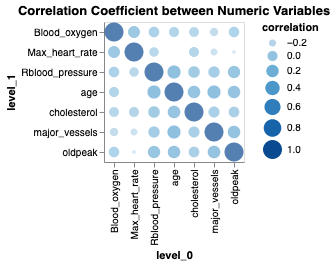

In [41]:
# make a correlation plot
cc_plot = (
    alt.Chart(corr_df)
    .mark_circle()
    .encode(
        alt.X("level_0:N"),
        alt.Y("level_1:N"),
        alt.Size("correlation"),
        alt.Color("correlation")
    )
    .properties(title="Correlation Coefficient between Numeric Variables")
)
cc_plot

# Predicting a Heart Attack

In [16]:
# To adhere to the Golden Rule, let's now split our dataset before anything else.
train_df, test_df = train_test_split(awake_df, test_size=0.2, random_state=77)
train_df.head()

,age,sex,chest_pain,Rblood_pressure,cholesterol,Fblood_sugar,Rest_ECG,Max_heart_rate,exercize_angina,oldpeak,slope,major_vessels,TStress_result,Heart_attack,Blood_oxygen
282,59.0,1.0,2.0,126.0,218.0,1.0,1.0,134.0,0.0,2.2,1.0,1.0,1.0,0.0,96.5
159,56.0,1.0,1.0,130.0,221.0,0.0,0.0,163.0,0.0,0.0,2.0,0.0,3.0,1.0,97.5
46,44.0,1.0,2.0,140.0,235.0,0.0,0.0,180.0,0.0,0.0,2.0,0.0,2.0,1.0,97.0
164,38.0,1.0,2.0,138.0,175.0,0.0,1.0,173.0,0.0,0.0,2.0,4.0,2.0,1.0,97.5
244,56.0,1.0,0.0,132.0,184.0,0.0,0.0,105.0,1.0,2.1,1.0,1.0,1.0,0.0,97.5


Find the distribution of our target values in `Heart_attack`.


In [17]:
class_dist = train_df.value_counts('Heart_attack')
class_dist

Heart_attack
1.0    131
0.0    111
dtype: int64

There are 131 heart attacks of the category 1 and 111 of the category 0. This means the classes are unbalanced, which is not unsual.

explain

## Before Preprocessing

Before preprocessing the feature vectors from the target feature, `Heart_attack`.

In [18]:
# Separate feature vectors from the target, Heart_attack.
X_train = train_df.drop(columns=["Heart_attack"])
y_train= train_df["Heart_attack"]

X_test = test_df.drop(columns=["Heart_attack"])
y_test = test_df["Heart_attack"]
X_train.head()

,age,sex,chest_pain,Rblood_pressure,cholesterol,Fblood_sugar,Rest_ECG,Max_heart_rate,exercize_angina,oldpeak,slope,major_vessels,TStress_result,Blood_oxygen
282,59.0,1.0,2.0,126.0,218.0,1.0,1.0,134.0,0.0,2.2,1.0,1.0,1.0,96.5
159,56.0,1.0,1.0,130.0,221.0,0.0,0.0,163.0,0.0,0.0,2.0,0.0,3.0,97.5
46,44.0,1.0,2.0,140.0,235.0,0.0,0.0,180.0,0.0,0.0,2.0,0.0,2.0,97.0
164,38.0,1.0,2.0,138.0,175.0,0.0,1.0,173.0,0.0,0.0,2.0,4.0,2.0,97.5
244,56.0,1.0,0.0,132.0,184.0,0.0,0.0,105.0,1.0,2.1,1.0,1.0,1.0,97.5


## Build Base Model with which to Compare Models

In [19]:
# Save our base model as dummy.
dummy = DummyClassifier(strategy='most_frequent')

# Use dummy to fit on the training set.
dummy.fit(X_train, y_train)

# Cross validate and save the results as a dataframe in the object dummy_scores. Be sure to return the train score.
dummy_scores = pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=5, return_train_score=True))
dummy_scores

,fit_time,score_time,test_score,train_score
0,0.000826,0.000411,0.530612,0.544041
1,0.000813,0.000385,0.551020,0.538860
2,0.000573,0.000181,0.541667,0.541237
3,0.000471,0.000159,0.541667,0.541237
4,0.000457,0.000160,0.541667,0.541237


Find the mean of the results in dummy_scores.

In [20]:
# Find the mean of each column in dummy_scores, and save object as dummy_mean.
dummy_mean = dummy_scores.mean()
dummy_mean

fit_time       0.000628
score_time     0.000259
test_score     0.541327
train_score    0.541323
dtype: float64

## Preprocessing the Data and Pipeline Building

In order to preprocess, first separate the features into their types (binary, ordinal etc.).

In [21]:
# let's check the dtypes in order to separate them
X_train.dtypes

age                 float64
sex                category
chest_pain         category
Rblood_pressure     float64
cholesterol         float64
Fblood_sugar       category
Rest_ECG           category
Max_heart_rate      float64
exercize_angina    category
oldpeak             float64
slope              category
major_vessels       float64
TStress_result     category
Blood_oxygen        float64
dtype: object

In [22]:
# Separate columns into feature types.
numeric_features = ["age", "Rblood_pressure","cholesterol", "Max_heart_rate", "Blood_oxygen", "major_vessels", "oldpeak"]
categorical_features = ["sex", "chest_pain", "Fblood_sugar", "Rest_ECG", "exercize_angina", "slope", "TStress_result"]
binary_features = ["sex", "Fblood_sugar", "exercize_angina" ]
target = ["Heart_attack"]

We have no missing values, and so no need to impute values.

In [23]:
# Make a pipeline for each of the four feature types.
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessor = make_column_transformer(
                                      (numeric_transformer, numeric_features)
                                      
                                      )

## Build Models with which to Compare Base Model

In [24]:
# Use RandomForestClassifier to build a pipe, rfc_pipe.
rfc_pipe = make_pipeline(preprocessor, RandomForestClassifier(class_weight ="balanced", random_state=77, n_estimators=10))
#rfc_pipe

In [25]:
# Fit rfc_pipe on the training set.
rfc_pipe.fit(X_train, y_train)

# Cross validate on the training using rfc_pipe. Save the results in a DataFrame.
rfc_scores =pd.DataFrame(cross_validate(rfc_pipe, X_train, y_train, cv=5, return_train_score=True))
rfc_scores

,fit_time,score_time,test_score,train_score
0,0.011491,0.002144,0.714286,0.994819
1,0.011255,0.002140,0.775510,0.994819
2,0.010421,0.001871,0.750000,0.989691
3,0.010236,0.001849,0.625000,0.979381
4,0.010096,0.001769,0.645833,0.989691


Find the mean of rfc_scores.

In [26]:
rfc_mean_scores = rfc_scores.mean()
rfc_mean_scores

fit_time       0.010700
score_time     0.001955
test_score     0.702126
train_score    0.989680
dtype: float64

In comparisson to the DummyClassifier, the scores from RandomClassifier are noticeably higher.

Let's tune the hyperparameters n_estimators and max_depth. For speed, **RandomizedSearchCV** is used below and not **GridSearchCV**.

In [27]:
import scipy
from scipy.stats import randint

rf_pipeline = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=123)
)

param_dist = {
    "randomforestclassifier__n_estimators": scipy.stats.randint(low=10, high=300),
    "randomforestclassifier__max_depth": scipy.stats.randint(low=2, high=20),
}

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_dist,
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring="accuracy",
    random_state=123,
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'Rblood_pressure',
                                                                                'cholesterol',
                                                             

In [28]:
# Calculate the best hyperparameter value for n_estimator and max_depth, and save as optimal_parameters.
optimal_parameters = random_search.best_params_

# Calculate the corresponding validation score, and save as optimal_score.
optimal_score = random_search.best_score_

optimal_parameters, optimal_score

({'randomforestclassifier__max_depth': 4,
  'randomforestclassifier__n_estimators': 86},
 0.7685699588477366)

In [29]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.137930,0.026341,0.012523,0.003549,15,108,"{'randomforestclassifier__max_depth': 15, 'ran...",0.753086,0.740741,0.7250,0.739609,0.011494,36
1,0.036077,0.005573,0.005034,0.002242,8,27,"{'randomforestclassifier__max_depth': 8, 'rand...",0.728395,0.740741,0.7000,0.723045,0.017057,49
2,0.162812,0.008712,0.010300,0.001980,12,133,"{'randomforestclassifier__max_depth': 12, 'ran...",0.765432,0.765432,0.7125,0.747788,0.024952,22
3,0.114719,0.005908,0.016182,0.001273,3,106,"{'randomforestclassifier__max_depth': 3, 'rand...",0.827160,0.728395,0.7250,0.760185,0.047379,6
4,0.177001,0.016393,0.014461,0.008381,19,136,"{'randomforestclassifier__max_depth': 19, 'ran...",0.765432,0.753086,0.7250,0.747840,0.016918,19
5,0.105533,0.003744,0.011692,0.005308,17,83,"{'randomforestclassifier__max_depth': 17, 'ran...",0.753086,0.740741,0.7250,0.739609,0.011494,36
6,0.259074,0.011146,0.021205,0.000819,2,234,"{'randomforestclassifier__max_depth': 2, 'rand...",0.839506,0.703704,0.7500,0.764403,0.056369,2
7,0.289719,0.008539,0.024046,0.001268,17,263,"{'randomforestclassifier__max_depth': 17, 'ran...",0.765432,0.740741,0.7375,0.747891,0.012474,14
8,0.119567,0.004492,0.009293,0.003272,6,106,"{'randomforestclassifier__max_depth': 6, 'rand...",0.790123,0.728395,0.7125,0.743673,0.033480,30
9,0.093600,0.002964,0.007822,0.002672,18,78,"{'randomforestclassifier__max_depth': 18, 'ran...",0.740741,0.740741,0.7125,0.731327,0.013313,45


## Score the model on the test set.

In [30]:
# Evaluate the best model from random_seach on the full training set.
training_score = random_search.score(X_train, y_train)
training_score

0.8760330578512396

In [43]:
# Evaluate the best model from random_seach on the full test set.
test_score = random_search.score(X_test, y_test)
test_score

0.819672131147541

/Users/nyandaredwood/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


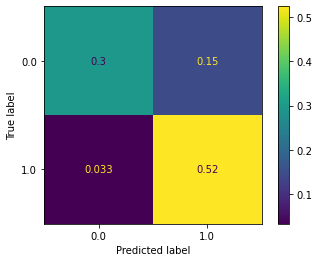

In [44]:
# Plot a confusion matrix on the test set using random_search 
cm_plot = plot_confusion_matrix(random_search, X_test, y_test, normalize="all")
cm_plot

In [31]:
# Print a classification report on X_test of random_search's best model.
print(classification_report(y_test, random_search.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.90      0.67      0.77        27
         1.0       0.78      0.94      0.85        34

    accuracy                           0.82        61
   macro avg       0.84      0.80      0.81        61
weighted avg       0.83      0.82      0.81        61

